In [1]:
import xarray as xr
import healpy as hp
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

Text(0.5, 1.0, 'ICON total precipitation 2020-01-26T00:00:00 HEALPix Zoom 1')

<Figure size 640x480 with 0 Axes>

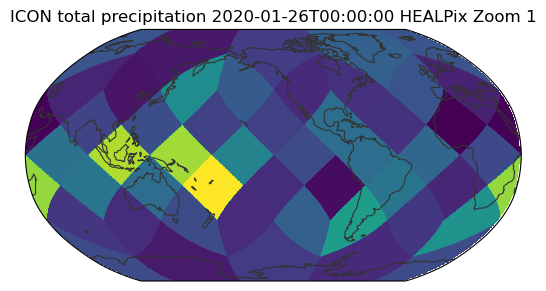

In [3]:
# read ICON model output
zoom = '1'
#file = '/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z' + zoom + '.zarr'
file = '/scratch/nf33/Healpix_data/ICON/PT1H_inst_z1_atm.zarr/'

ds2d = xr.open_zarr(file)

pr_icon = ds2d['pr'] #precipitation

this_time = '2020-01-26T00:00:00'
egh.healpix_show(pr_icon.sel(time = this_time).squeeze(), cmap = 'viridis')
plt.title('ICON total precipitation ' + this_time + ' HEALPix Zoom '+ zoom)


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: merging cohorts
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


Text(0.5, 1.0, 'icon monthly total precipitation for February - HEALPix Zoom 1')

<Figure size 640x480 with 0 Axes>

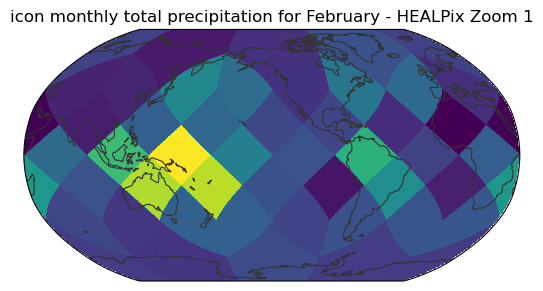

In [4]:
pr_icon_month = pr_icon.groupby("time.month").mean() # Calculate monthly mean.

this_month = 2
egh.healpix_show(pr_icon_month.sel(month = this_month).squeeze(), cmap = 'viridis')
plt.title('icon monthly total precipitation for February - HEALPix Zoom '+ zoom)

In [5]:
# read imerg data
file_IMERG = '/g/data/ia39/aus-ref-clim-data-nci/frogs/data/1DD_V1/IMERG_V07B_FC/IMERG_V07B_FC.1DD.*.nc'

pr_imerg = xr.open_mfdataset(file_IMERG, combine = 'nested', concat_dim = 'time')
pr_imerg_monthly = pr_imerg['rain'].groupby('time.month').mean() # Calculate monthly mean.


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


Text(0.5, 1.0, 'IMERG total precipitation for February 2020')

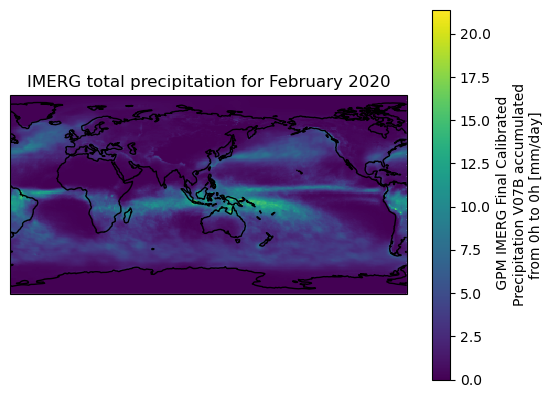

In [6]:
# plot for IMERG monthly mean
projection = ccrs.PlateCarree(central_longitude = 120)

fig, ax = plt.subplots(subplot_kw = {"projection": projection})
pr_imerg_monthly.sel(month = 2).plot(cmap = 'viridis', transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('IMERG total precipitation for February 2020')

In [7]:
#regridding for maritime continent
pr_imerg_monthly_mari = pr_imerg_monthly.sel(lon = slice(100, 150), lat = slice(-13, 13))


In [8]:
def get_nn_lon_lat_index(nside, lons, lats):
    """
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[("lat", lats), ("lon", lons)],
    )

In [9]:
# Find the HEALPix pixels that are closest to the imerg grid

# longitudes and latitudes for the imerg grid
lon = pr_imerg_monthly_mari['lon'].values
lat = pr_imerg_monthly_mari['lat'].values

# nside for icon simulation, it should be equal to 2**zoom
this_nside = hp.get_nside(pr_icon_month)

cells = get_nn_lon_lat_index(this_nside, lon, lat) 

cells

<xarray.DataArray (lat: 26, lon: 50)> Size: 10kB
array([[20, 20, 20, ..., 39, 39, 39],
       [20, 20, 20, ..., 39, 26, 26],
       [20, 20, 21, ..., 26, 26, 26],
       ...,
       [23, 23, 21, ..., 26, 26, 26],
       [23, 23, 23, ...,  4, 26, 26],
       [23, 23, 23, ...,  4,  4,  4]])
Coordinates:
  * lat      (lat) float32 104B -12.5 -11.5 -10.5 -9.5 ... 9.5 10.5 11.5 12.5
  * lon      (lon) float32 200B 100.5 101.5 102.5 103.5 ... 147.5 148.5 149.5

Text(0.5, 1.0, 'ICON total precipitation for February 2020')

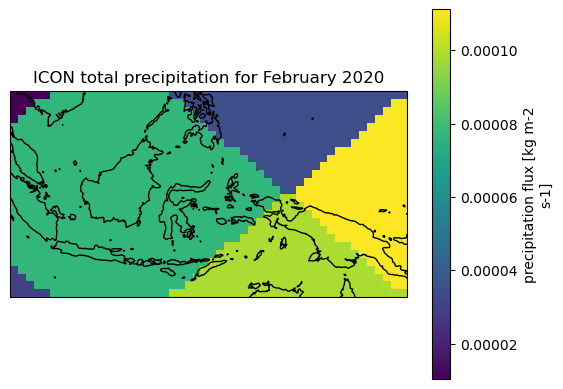

In [10]:
# Plot icon simulation regrided to lon/lat from imerg
fig, ax = plt.subplots(subplot_kw = {"projection": projection})
pr_icon_month.isel(cell = cells).sel(month = 2).plot(cmap = 'viridis', transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('ICON total precipitation for February 2020')

In [11]:
# calculate the difference

pr_icon_month_regrided = pr_icon_month.isel(cell = cells) # regriding
#pr_icon_month_regrided = pr_icon_month_regrided.rename({'lon': 'longitude', 'lat': 'latitude'}) # we need to change the names to match ERA5 data

Text(0.5, 1.0, 'Difference ICON - IMERG, surface temperature 02/2020')

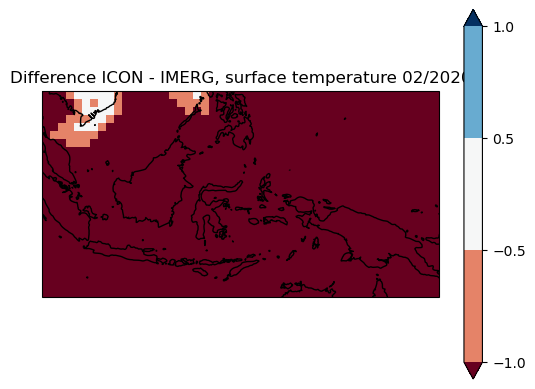

In [12]:
difference = pr_icon_month_regrided.sel(month = 2) - pr_imerg_monthly_mari.sel(month = 2) # difference ICON - ERA5

fig, ax = plt.subplots(subplot_kw = {"projection": projection})
difference.plot(ax = ax, cmap = 'RdBu', transform = ccrs.PlateCarree(),levels=[-1,-0.5,0.5,1],extend = 'both')
ax.coastlines()
ax.set_title('Difference ICON - IMERG, surface temperature 02/2020')

In [ ]:
# for test before 

In [ ]:
# for getting regridded file, below

In [3]:
import xarray as xr
import healpy as hp
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import pandas as pd

# start and end time 
start_time = '2020-04-01T00:00:00'
end_time = '2021-03-31T23:00:00'  

# get hourly time series
time_series = pd.date_range(start=start_time, end=end_time, freq='H')

# convert to ISO 
time_strings = time_series.strftime('%Y-%m-%dT%H:%M:%S').tolist()

path='/g/data/nf33/hk25_DOCmeso/temp_data/observations/IMERG/doc_metrics/mean_area/IMERG/mean_area_IMERG_hrly_100-149_-13-13_3600x1800_2020-04_2021-03/'
fh = xr.open_dataset(path+'mean_area_IMERG_hrly_100-149_-13-13_3600x1800_2020-04_2021-03_var_2020_4_1.nc')
pr_mean = fh['var']
#lat = fh.lat
#lon = fh.lon
time = fh.time
fh.close()

# read ICON model output
zoom = '10'
#file = '/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z' + zoom + '.zarr'
file = '/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z10_atm.zarr/'
ds2d = xr.open_zarr(file)
pr_icon = ds2d['pr'] #precipitation

this_time = '2020-01-26T00:00:00'
#pr_icon_month = pr_icon.groupby("time.month").mean() # Calculate monthly mean.
this_month = 2

# read imerg data
file_IMERG = '/g/data/ia39/aus-ref-clim-data-nci/gpm/data/V07/2020/3B-HHR.MS.MRG.3IMERG.*.V07A.nc'

pr_imerg = xr.open_mfdataset(file_IMERG, combine = 'nested', concat_dim = 'time')
pr_imerg_monthly = pr_imerg['precipitation'].groupby('time.month').mean() # Calculate monthly mean.

#regridding for maritime continent
pr_imerg_monthly_mari = pr_imerg_monthly.sel(lon = slice(100, 150), lat = slice(-13, 13))

def get_nn_lon_lat_index(nside, lons, lats):
    """
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[("lat", lats), ("lon", lons)],
    )
# Find the HEALPix pixels that are closest to the imerg grid

# longitudes and latitudes for the imerg grid
lon = pr_imerg_monthly_mari['lon'].values
lat = pr_imerg_monthly_mari['lat'].values
# nside for icon simulation, it should be equal to 2**zoom
for time in time_series[:10]:
    pr_icon_snap = pr_icon.sel(time = time) # select the time point
    this_nside = hp.get_nside(pr_icon)
    cells = get_nn_lon_lat_index(this_nside, lon, lat) 
    pr_icon_regrided = pr_icon_snap.isel(cell = cells)# regriding
    ds = pr_icon_regrided.to_dataset(name = 'pr')
    if 'hiopy::enable' in ds['pr'].attrs:
        del ds['pr'].attrs['hiopy::enable']
    ds['lat'] = lat   #!!this is not right:ds['xloc_final'] = np.sort(xloc_final)
    ds['lon'] = lon
    ds.to_netcdf('/g/data/w28/ym7079/Hackthon/DOC/hk25-AusNode-DOCmeso/get_metrics/Yinglin/ICON_regridding/'+'ICON'+str(time)[:-9]+'_'+str(time)[:-9:-6]+'.nc')

#ds.to_netcdf('/g/data/w28/ym7079/Hackthon/DOC/hk25-AusNode-DOCmeso/get_metrics/Yinglin/ICON_regridding/test.nc')
   

    
    


/jobfs/140879820.gadi-pbs/ipykernel_958362/1228428035.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_series = pd.date_range(start=start_time, end=end_time, freq='H')
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
